# Exercise 5: Generate forcing for any region from CMIP6 for HBV model

In this notebook you will generate forcing from CMIP6 for your own HBV model. For forcing generation we use the eWaterCycle generic forcing generator. This will download the required CMIP6 data from a remote ESGF server

You have to supply your own shapefile. Upload it inside the "Forcing" directory, see the file browser on your left (if you have done the previous exercises, you have already uploaded it). We have uploaded a shapefile for the Rhine, to be able to test this notebook ourselves.

We have seperated generating the forcing and running the model into two notebooks because generating the forcing is quite heavy on the hardware and we want to minimize the number of times you have to do that. After generating your forcing in this notebook, it will be saved so we can load it later without having to re-run it.

Once you have this forcing, you can change the other notebooks to run your model using this forcing.


In [1]:
# Required dependencies, note that we do not need to import the model for only generating forcing
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import xarray as xr
import shutil

/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set lisflood_fraser loaded in config but /data/shared/parameter-sets/lisflood_fraser does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set lisflood_fraser loaded in config but /data/shared/parameter-sets/lisflood_fraser/settings_lat_lon-Run.xml does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set pcrglobwb_rhinemeuse_30min loaded in config but /data/shared/parameter-sets/pcrglobwb_rhinemeuse_30min does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-p

In [2]:
# Name of your shapefile/region without extension:
own_region = "HN4326"  # for example: "Rhine"

if own_region == None:  # if nothing is provided, the Rhine shapefile will be used
    own_region = "Rhine"

In [5]:
# Shapefile that describes the basin we want to study.
path = Path.cwd()
forcing_path = path / "Forcing"
shapeFile = forcing_path / f"{own_region}.shp"

# Location to save forcing results
saveLocation = forcing_path / f"{own_region}ForcingCMIP"

# Period of interest. 
# Make sure that ERA5 is available on your machine for this period. 
# On our machine ERA5 is available from 1990 up until 2019.
# For the course ENVM1502 ERA5 is available from 2010-01-01 until 2014-12-31
# Choose a period for which you have observation data of discharge available!
experiment_start_time = "2010-01-01T00:00:00Z"
experiment_end_time = "2014-12-31T00:00:00Z"


In [6]:
# CMIP6 information, you can change this, but do research on what this means before changing anything!

cmip_dataset = {
    "dataset": "EC-Earth3",
    "project": "CMIP6",
    "grid": "gr",
    "exp": "historical",
    "ensemble": "r6i1p1f1",
}

Forcing is created using the LumpedMakkinkForcing option in eWaterCycle. This selects rainfall and precipitation from the indicated dataset for the given time period and averages over the indicated shape. It calculates potential evaporation using the approximation by Makkink. The result is two NetCDF files and a yaml file. This can later be loaded using ```ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(forcingLocation)```. Depending on how busy the machine is and how big the area is you are generating forcing for, the cell below can take minutes to run.

In [7]:
CMIP6_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
    dataset=cmip_dataset,
    start_time=experiment_start_time,
    end_time=experiment_end_time,
    shape=shapeFile.absolute(),
)

In [8]:
print(CMIP6_forcing)

LumpedMakkinkForcing(
    start_time='2010-01-01T00:00:00Z',
    end_time='2014-12-31T00:00:00Z',
    directory=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/esmvaltool_output/ew
crep084r9wi3_20250318_150555/work/diagnostic/script'),
    shape=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing/HN4326.shp'),
    filenames={
        'pr': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_pr_gr_2010-2014.nc',
        'tas': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_tas_gr_2010-2014.nc',
        'rsds': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_rsds_gr_2010-2014.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

Let's make a plot to look at this forcing

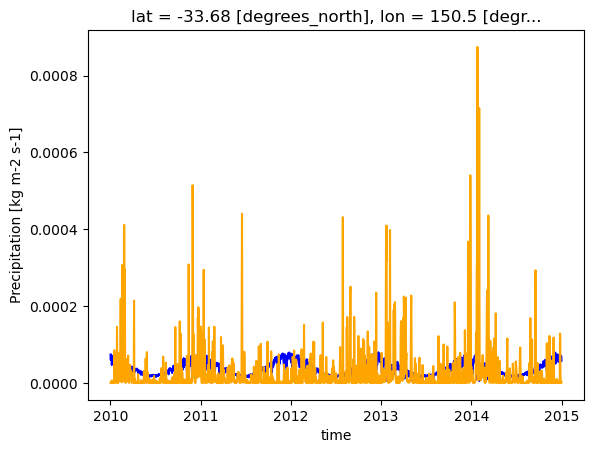

In [9]:
CMIP6_forcing.to_xarray()["evspsblpot"].plot(color="blue")
CMIP6_forcing.to_xarray()["pr"].plot(color="orange")

Finally, the forcing is saved deep in an ESMValTool directory that was just created. For easy loading in other notebooks, let's save it in a better location.

In [10]:
shutil.copytree(CMIP6_forcing.directory,saveLocation)

PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing/HN4326ForcingCMIP')